In [7]:
# CM2016 
# use package SimpleITK, SciPy and Jupyter
import SimpleITK as sitk
import numpy as np
import seaborn as sns
import cv2
from matplotlib import pyplot as plt

In [99]:
# path to cropped nii.gz image 
ptw_cropped = "./MRI/cropped/PDW_Bacon_cropped.nii.gz"

sitk_pdw = sitk.ReadImage(ptw_cropped)
# get image information
print("Size in Voxel: " ,sitk_pdw.GetSize())
print("Spacing in mm: ", sitk_pdw.GetSpacing())
print("Origin in mm: ", sitk_pdw.GetOrigin())

Size in Voxel:  (155, 121, 75)
Spacing in mm:  (0.4765625, 0.4765625, 4.0)
Origin in mm:  (37.137298583984375, -30.402999877929688, -148.0)


In [9]:
# be cautios, sitk swaps x and z axis
pdw = sitk.GetArrayFromImage(sitk_pdw)
np.shape(pdw)

(75, 121, 155)

In [10]:
# Check if array has values by choosing an arbitrary slice
print(pdw[10])

[[ 3.26286415  3.36183759  3.22930504 ...  0.6208637   1.23568384
   1.02456713]
 [ 4.24506305  4.19198485  5.01778602 ...  0.39766997  0.82715417
   0.73995362]
 [ 4.80533595  4.47974005  5.86593368 ...  0.80710816  1.06725725
   1.10781262]
 ...
 [ 8.70311291  8.33356609 10.28017708 ...  1.87650928  2.07376154
   2.15459302]
 [11.41918542 14.03850609 11.36859131 ...  1.3276322   1.82465301
   2.34906961]
 [10.98930445 14.60157937 13.44425401 ...  1.90579294  1.88165744
   1.66497152]]


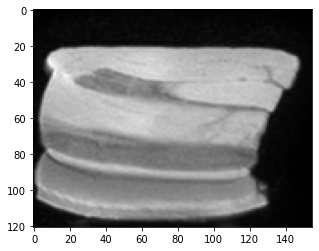

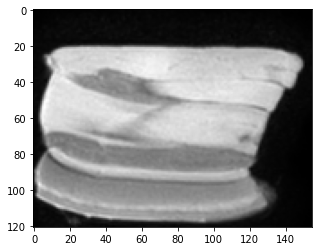

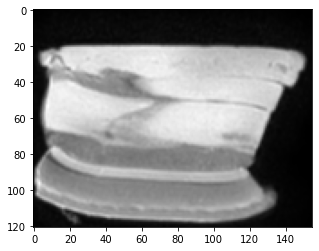

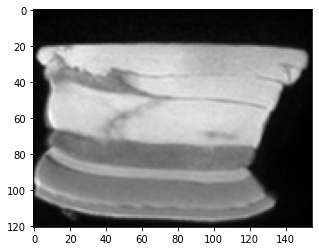

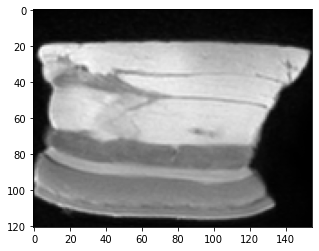

In [198]:
# show some slices of image
k = 10
plt.imshow(pdw[k-2], cmap='gray')
plt.show()
plt.imshow(pdw[k-1], cmap='gray')
plt.show()
plt.imshow(pdw[k], cmap='gray')
plt.show()
plt.imshow(pdw[k+1], cmap='gray')
plt.show()
plt.imshow(pdw[k+2], cmap='gray')
plt.show()

<AxesSubplot:ylabel='Count'>

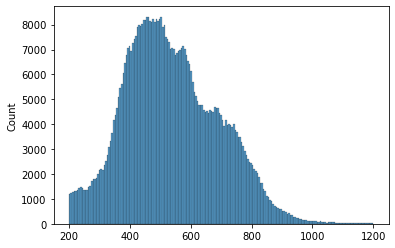

In [83]:
# Plot histogram without background value (0)
sns.histplot(pdw.flatten(), binrange=(200,1200))

It can be seen that there is no easy distinction between different pixel values, so it it not sensible to segment the image just based on the Grayscale values. The pixel with a value < 200 are very likely background noise.

<AxesSubplot:ylabel='Count'>

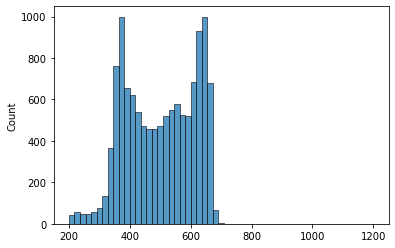

In [173]:
# Plot histogram without background value (0) for single slice
sns.histplot(pdw[10].flatten(), binrange=(200,1200))

It can be seen, that there are two larger maxima. Thus, it might be sensible to segment in a slice-wise manner.

In [85]:
# use k means clustering to cluster pixels into 3 categories (background, water, fat) -> !!! What about skin?
# use openCV to segment one slice
# initiate 3D label image
label_3D = np.zeros(pdw.shape)

for i in range(label_3D.shape[0]):
    img_slice = pdw[i]
    vectorized_slice = img_slice.flatten()
    vectorized_slice = np.float32(vectorized_slice)
    criteria = (cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
    attempts = 10
    K = 3 # number of classes (Background, Water, Fat)
    ret,label,center = cv2.kmeans(vectorized_slice, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    
    # map labels (background = 0, fat = 1, water = 2) Water is the brightest in the PDW image
    if (center != center.sort()).all():
        for k in range(len(label)):
            if label[k] == center.argmin():
                label[k] = 0
            elif label[k] == center.argmax():
                label[k] = 2
            else:
                label[k] = 1
    
    label_3D[i] = label.reshape(img_slice.shape)


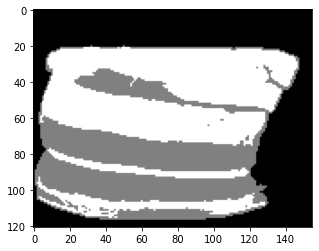

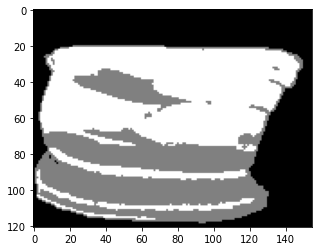

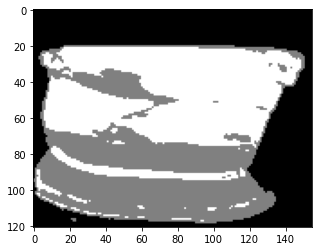

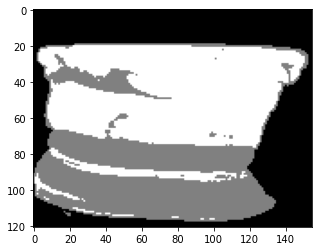

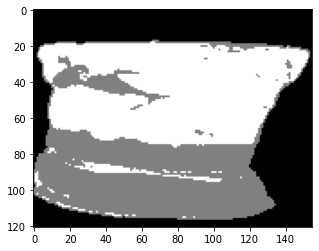

In [104]:
k = 10
plt.imshow(label_3D[k-2], cmap='gray')
plt.show()
plt.imshow(label_3D[k-1], cmap='gray')
plt.show()
plt.imshow(label_3D[k], cmap='gray')
plt.show()
plt.imshow(label_3D[k+1], cmap='gray')
plt.show()
plt.imshow(label_3D[k+2], cmap='gray')
plt.show()


In [215]:
# use morphological closing operation to clean up segmentation

# define kernel for closign operation: using small kernel to preserve smaller features
kernel = np.ones((2,2),np.uint8)

# define new array for processed labels 
label_3D_closed = np.zeros(np.shape(label_3D))

# apply closing operation slice wise
for k in range(np.shape(label_3D)[0]):
    label_3D_closed[k] = cv2.morphologyEx(label_3D[k], cv2.MORPH_CLOSE, kernel)


label


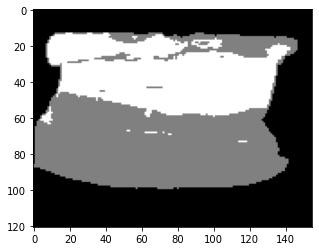

label after closing operation


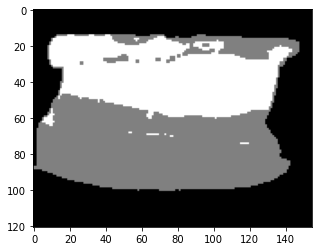

In [221]:
# show labels and cleaned label by choosing an arbitrary slice 
print("label")
plt.imshow(label_3D[25], cmap='gray')
plt.show()
print("label after closing operation")
plt.imshow(label_3D_closed[25], cmap='gray')
plt.show()

In [222]:
# calculate watery tissue and fat tussue by counting number of respective voxels
num_voxel_fat = 0
num_voxel_water = 0
for i in label_3D_closed.flatten():
    if i == 1:
        num_voxel_fat += 1
    if i == 2: 
        num_voxel_water += 1
        
# print relative fat and water content:
print("relative fat in tissue:", num_voxel_fat/(num_voxel_fat+num_voxel_water))
print("relative water in tissue:", num_voxel_water/(num_voxel_fat+num_voxel_water))

relative fat in tissue: 0.551269877252861
relative water in tissue: 0.44873012274713897


In [227]:
def max_consecutive_ones(arr):
    """Inefficient method to determine the max number of consecutive number of ones in array"""
    max = 0
    num_ones_tmp = 0
    for i in arr:
        if i == 1:
            num_ones_tmp += 1
        else:
            if num_ones_tmp > max:
                max = num_ones_tmp
            num_ones_tmp = 0
    return max

In [231]:
# loops over slices to find max thickness of fatty and watery tissue
max_thickness_fat = 0
max_thickness_water = 0

max_thickness_per_slice_fat = []
max_thickness_per_slice_water = []

for slice in label_3D_closed:
    # might not need the following two lines if only interested in total max
    # keep to be able to keep track of what max thickness is per slice
    max_thick_in_slice_fat = 0 #find the maximum thickness in slice for fat
    max_thick_in_slice_water = 0 #find the maximum thickness in slice for water
    for idx in range(np.shape(slice)[1]):
        line = slice[:,idx]
        thick_fat = max_consecutive_ones([1 if a == 1 else 0 for a in line])
        thick_water = max_consecutive_ones([1 if a == 2 else 0 for a in line])
        
        if thick_fat > max_thick_in_slice_fat:
            max_thick_in_slice_fat = thick_fat
        if thick_water > max_thick_in_slice_water:
            max_thick_in_slice_water = thick_water
        
        # reset variables
        thick_fat = 0
        thick_water = 0
    
    if max_thick_in_slice_fat > max_thickness_fat:
        max_thickness_fat = max_thick_in_slice_fat
    if max_thick_in_slice_water > max_thickness_water:
        max_thickness_water = max_thick_in_slice_water
    
    max_thickness_per_slice_fat.append(max_thick_in_slice_fat)
    max_thickness_per_slice_water.append(max_thick_in_slice_water)
    
    # reset variables
    max_thick_in_slice_fat = 0
    max_thick_in_slice_water = 0

# print(max_thickness_per_slice_fat)
print("thickness of fat in bacon [voxel]: ", max_thickness_fat)
# print(max_thickness_per_slice_water)
print("thickness of water in bacon [voxel]: ", max_thickness_water)

# print thickness of thickest fat and water in mm
print(max_thickness_fat * sitk_pdw.GetSpacing()[1], "mm")
print(max_thickness_water * sitk_pdw.GetSpacing()[1], "mm")


thickness of fat in bacon [voxel]:  80
thickness of water in bacon [voxel]:  67
38.125 mm
31.9296875 mm


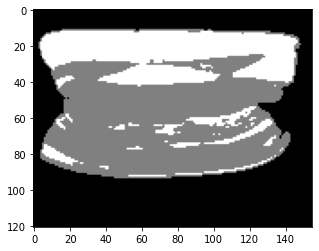

In [229]:
# find slice in which thickest layer of fat is and visualize slice
slice_num = np.where(max_thickness_per_slice_fat == np.int32(max_thickness_fat))[0]
plt.imshow(label_3D[slice_num[0]], cmap='gray')
plt.show()

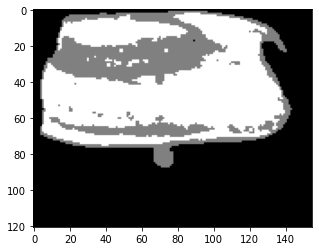

In [230]:
# find slice in which thickest layer of water is and visualize slice
slice_num = np.where(max_thickness_per_slice_water == np.int32(max_thickness_water))[0]
plt.imshow(label_3D[slice_num[0]], cmap='gray')
plt.show()